# Time Series Modeling
### By Chase Whitman

In [2]:
# Dependencies
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import meanabs, mse, rmse

import pmdarima as pm

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read in data
df = pd.read_csv('..//Datasets//teleco_time_series.csv')

# Box-Jenkins method

### Identification

In [6]:
df.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


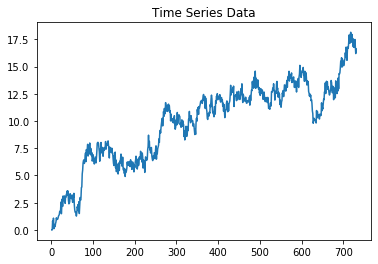

In [7]:
# Plot line graph of time series
plt.plot(df.Day, df.Revenue)
plt.title('Time Series Data')
plt.show()

In [8]:
# Check for gaps in measurement and length
if [df.Day.values == range(1, len(df)+1)]:
    print('There are NO gaps in measurements.')
else:
    print('Gaps in measurements.')

# Check for reptition in measurement    
if len(df) == len(df.Day.unique()):
    print('Only one measurement was recorded per day.')
else:
    print('Multiple measurements taken in one day.')

# Check for missing values
if not df.Revenue.isna().any():
    print('No null values')
else:
    print('Missing values')

There are NO gaps in measurements.
Only one measurement was recorded per day.
No null values


In [9]:
# Set day value as index
df = df.set_index('Day')
df.head()

,Revenue
Day,
1,0.000000
2,0.000793
3,0.825542
4,0.320332
5,1.082554


In [10]:
# Calculate seasonality and trend
decomp = seasonal_decompose(df.Revenue, period=90)

<Figure size 1152x576 with 0 Axes>

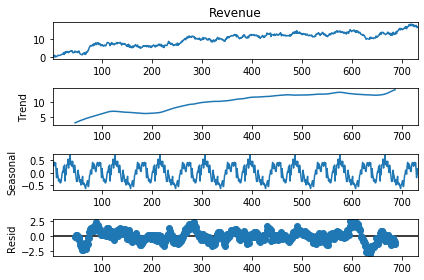

In [11]:
plt.figure(figsize=(16,8))
decomp.plot()
plt.show()

In [12]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(8,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # Print the test statistic and the p-value
    adf = adfuller(timeseries)
    print('ADF Statistic:', adf[0])
    print('P-value:', adf[1])

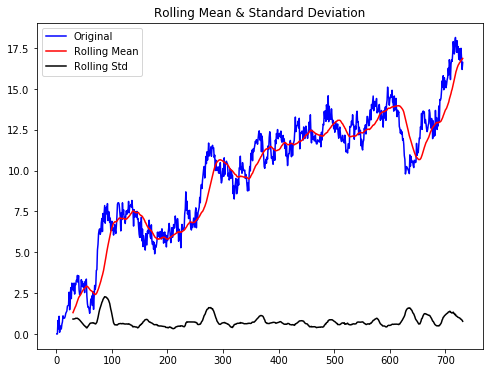

Results of Dickey-Fuller Test:
ADF Statistic: -1.9246121573101804
P-value: 0.320572815079398


In [13]:
# Check for stationarity of normal dataset
test_stationarity(df)

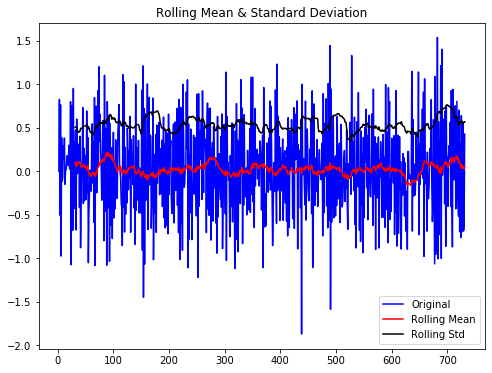

Results of Dickey-Fuller Test:
ADF Statistic: -44.874527193875984
P-value: 0.0


In [14]:
# Check for stationarity with first difference
df['diff1'] = df.diff().dropna()
test_stationarity(df.diff1.dropna())

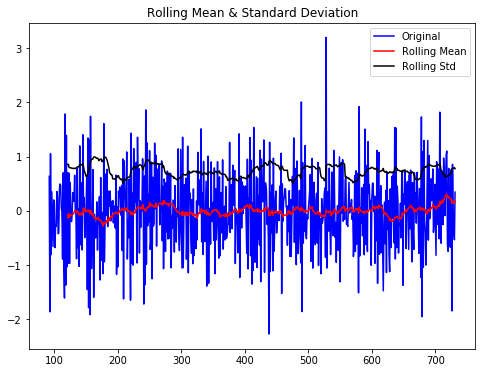

Results of Dickey-Fuller Test:
ADF Statistic: -12.180912307367787
P-value: 1.3522495328465237e-22


In [15]:
# Check for stationarity with seasonal diff
df['seasonal_diff'] = df.Revenue.diff().diff(90).dropna()
test_stationarity(df.seasonal_diff.dropna())

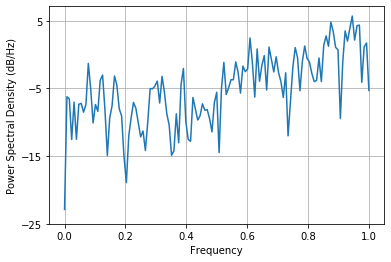

In [16]:
# Spectral Density
plt.psd(df.seasonal_diff.dropna())
plt.show()

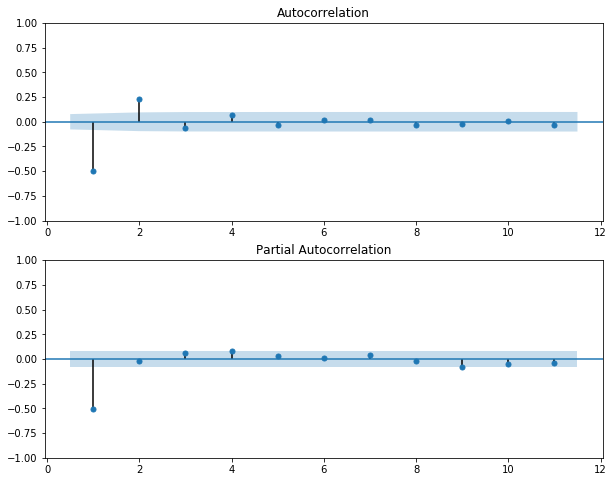

In [17]:
# Identify best non-seasonal order of model
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))
# Make ACF Plot
plot_acf(df.seasonal_diff[91:], lags=11, zero=False, ax=ax1)
# Make PACF Plot
plot_pacf(df.seasonal_diff[91:], lags=11, zero=False, ax=ax2)
plt.show()

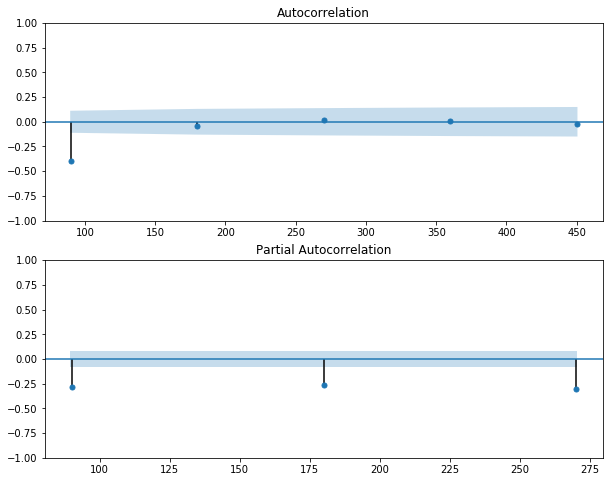

In [18]:
# Identify best seasonal order of model
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))
# Make ACF Plot
plot_acf(df.seasonal_diff.dropna(), lags=[90, 180, 270, 360, 450], zero=False, ax=ax1)
# Make PACF Plot
plot_pacf(df.seasonal_diff.dropna(), lags=[90, 180, 270], zero=False, ax=ax2)
plt.show()

### Estimation

In [19]:
# Split the data into train and test sets
train, test = train_test_split(df, train_size=.8, shuffle=False, random_state=42)

In [20]:
# Create Seasonal ARIMA model
arima = SARIMAX(train.Revenue, order=(0,1,2), seasonal_order=(0,1,1,90), trend='c')
results = arima.fit()

### Model Diagnostics

In [21]:
# Model evaluation
mae = np.mean(np.abs(results.resid))
print('Mean absolute error of residuals: ', mae)

Mean absolute error of residuals:  0.43881359530436703


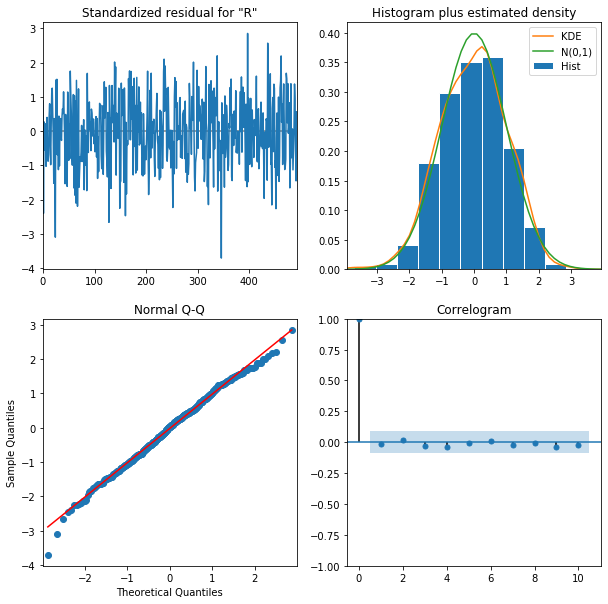

In [22]:
# Plot model diagnostics
results.plot_diagnostics(figsize=(10,10))
plt.show()

In [23]:
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              Revenue   No. Observations:                  584
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 90)   Log Likelihood                -398.042
Date:                              Sat, 13 Nov 2021   AIC                            806.084
Time:                                      16:27:46   BIC                            827.087
Sample:                                           0   HQIC                           814.330
                                              - 584                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0083      0.008     -1.078      0.281      -0.023       0.007
ma.L1         -0.50

### Forecasting

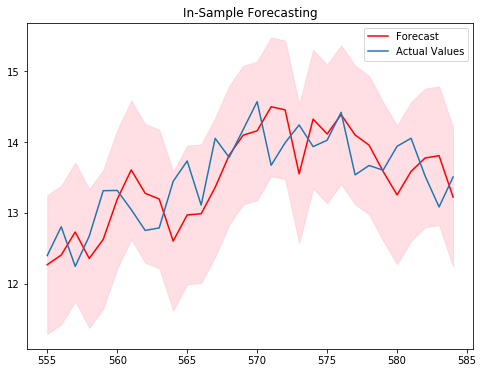

In [24]:
# In-sample forecasting
forecast = results.get_prediction(start=-30)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']

# Plot forecasts
plt.figure(figsize=(8,6))
plt.plot(mean_forecast, color='red', label='Forecast')
plt.plot(train.Revenue.iloc[-30:], label='Actual Values')
plt.fill_between(mean_forecast.index, lower_limits, upper_limits, color='pink', alpha=0.5)
plt.title('In-Sample Forecasting')
plt.legend()
plt.show()

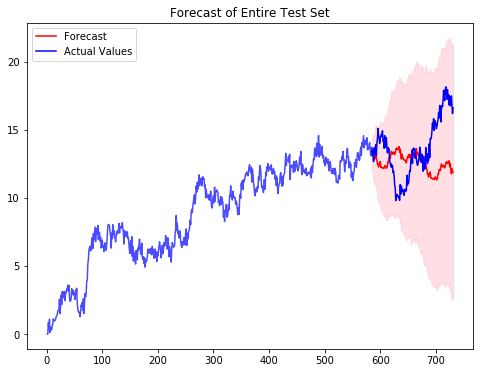

In [25]:
# Out of sample forecasting
start = 585
end = 731

forecast = results.get_prediction(start=585, end=731, dynamic=True)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']

# Plot forecasts
plt.figure(figsize=(8,6))
plt.plot(mean_forecast, color='red', label='Forecast')
plt.plot(test.Revenue, color='blue', label='Actual Values')
plt.plot(train.Revenue, color='blue', alpha=0.7)
plt.fill_between(mean_forecast.index, lower_limits, upper_limits, color='pink', alpha=0.5)
plt.title('Forecast of Entire Test Set')
plt.legend(loc='upper left')
plt.show()

In [26]:
# Calculate errors
print('MAE:', meanabs(mean_forecast, test.Revenue))
print('MSE:', mse(mean_forecast, test.Revenue))
print('RMSE:', rmse(mean_forecast, test.Revenue))

MAE: 2.2520837520489945
MSE: 7.725909856742586
RMSE: 2.779552096425355


### Walk forward validation

In [27]:
def update_metrics(mean_forecast, test):
    ''' Update metrics list based on test size'''
    if len(test) >= 30:
        mae_list.append(meanabs(mean_forecast, test.Revenue[:30]))
        mse_list.append(mse(mean_forecast, test.Revenue[:30]))
        rmse_list.append(rmse(mean_forecast, test.Revenue[:30])) 
        
    else:
        ind = len(test)
        mae_list.append(meanabs(mean_forecast[:ind], test.Revenue))
        mse_list.append(mse(mean_forecast[:ind], test.Revenue))
        rmse_list.append(rmse(mean_forecast[:ind], test.Revenue))
        

In [28]:
# Walk forward validation with 30-day windows
mae_list = list()
mse_list = list()
rmse_list = list()

test_df = test.copy()
series_count=1

for i in range(test.index[0], test.index[-1], 30):
    
    # If i is first value, forecast next thirty day revenue
    if i == test.index[0]:
        forecast = results.get_prediction(start=i+1, end=i+30, dynamic=True)
        mean_forecast = forecast.predicted_mean
        
        # Update metrics lists
        update_metrics(mean_forecast, test)
        
        # Update forecast df
        series_num = f'Forecast_{series_count}'
        test_df[series_num] = mean_forecast
        series_count += 1
    
    else:
        # Walk-forward thirty days and retrain models
        train, test = df.loc[:i], df.loc[i:]
        arima = SARIMAX(train.Revenue, order=(0,1,2), seasonal_order=(0,1,1,90), trend='c')
        results = arima.fit()
        forecast = results.get_prediction(start=i, end=i+29, dynamic=True)
        mean_forecast = forecast.predicted_mean
        
        # Update metrics lists
        update_metrics(mean_forecast, test) 
        
        # Update forecast df
        series_num = f'Forecast_{series_count}'
        test_df[series_num] = mean_forecast
        series_count += 1

In [29]:
# Print metric averages after walk forward validation
print('MAE:', np.mean(mae_list))
print('MSE:', np.mean(mse_list))
print('RMSE:', np.mean(rmse_list))

MAE: 1.7955137365194744
MSE: 4.889853326971666
RMSE: 2.068830973063636


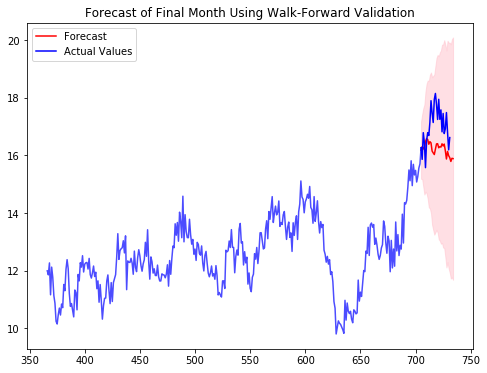

In [30]:
# Plot final month forecasts against true values
forecast = results.get_prediction(start=i, end=i+29, dynamic=True)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']

# Plot forecasts
plt.figure(figsize=(8,6))
plt.plot(mean_forecast, color='red', label='Forecast')
plt.plot(test.Revenue, color='blue', label='Actual Values')
plt.plot(train.Revenue[365:], color='blue', alpha=0.7)
plt.fill_between(mean_forecast.index, lower_limits, upper_limits, color='pink', alpha=0.5)
plt.title('Forecast of Final Month Using Walk-Forward Validation')
plt.legend(loc='upper left')
plt.show()

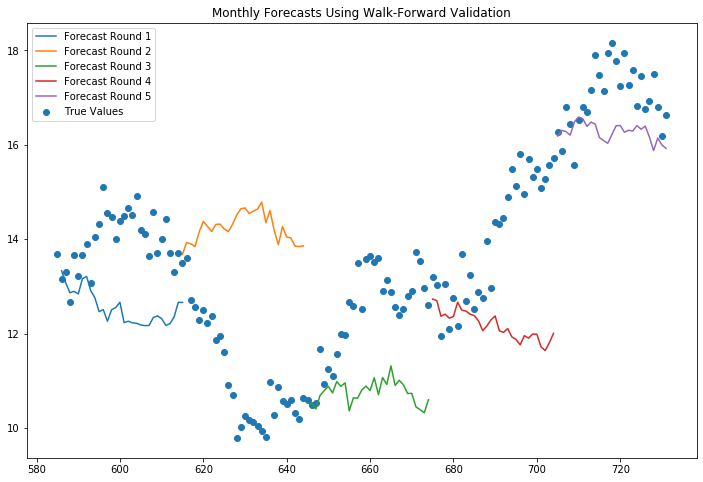

In [31]:
# Plot all monthly forecasts against true values
plt.figure(figsize=(12,8))
plt.scatter(test_df.index, test_df.Revenue, label='True Values')
plt.plot(test_df.Forecast_1, label='Forecast Round 1')
plt.plot(test_df.Forecast_2, label='Forecast Round 2')
plt.plot(test_df.Forecast_3, label='Forecast Round 3')
plt.plot(test_df.Forecast_4, label='Forecast Round 4')
plt.plot(test_df.Forecast_5, label='Forecast Round 5')
plt.title('Monthly Forecasts Using Walk-Forward Validation')
plt.legend(loc='upper left')
plt.show()

In [33]:
# # Export dataset
#df.to_csv('./task1_cleaned_data.csv')